### Import Libraries

In [3]:
import pickle
import re
import numpy as np
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import unicodedata
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
nltk.download('wordnet')
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json
from keras.models import Sequential
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D,GlobalMaxPooling1D,SpatialDropout1D,Flatten,GRU, Embedding, Dropout, Activation
from keras.optimizers import Adam
from tensorflow.keras.models import Model






[nltk_data] Downloading package wordnet to /Users/kush/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


ModuleNotFoundError: No module named 'scipy'

### Load Dataset

In [6]:
import pandas as pd
data = pd.read_csv('emotion_data.csv')
data = data.drop(['index'],axis=1)
data.head()

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [102]:
count_df = data[['emotions','text']].groupby('emotions').aggregate({'text':'count'}).reset_index().sort_values('text',ascending=False)
count_df

,emotions,text
2,joy,141067
4,sadness,121187
0,anger,57317
1,fear,47712
3,love,34554
5,surprise,14972


In [121]:
print("There are {} observations and {} features in this dataset. \n".format(data.shape[0],data.shape[1]))

print("There are {} types of emotions in this dataset such as {}... \n".format(len(data.emotions.unique()),
                                                                           ", ".join(data.emotions.unique()[0:5])))


There are 416809 observations and 2 features in this dataset. 

There are 6 types of emotions in this dataset such as sadness, joy, love, anger, fear... 



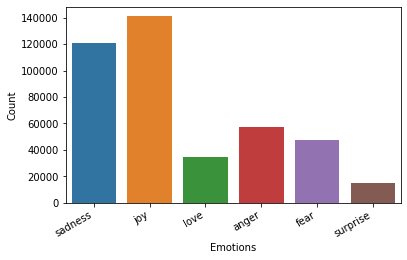

In [128]:
fig,axl= plt.subplots()
sns.countplot(x='emotions',data=data)
plt.xlabel("Emotions")
plt.ylabel("Count")
fig.autofmt_xdate()
plt.show()

### Word Cloud

In [117]:
sadness_words = []
for i in list(data.emotions[data.emotions=='sadness'].index):
    sadness_words.append(data.text[i])

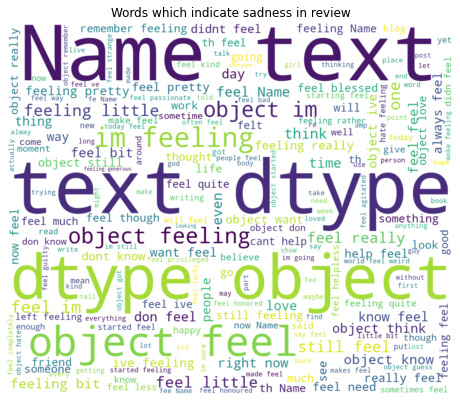

In [123]:
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,background_color = 'white',width=1200,height=1000).generate(str(sadness_words))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Words which indicate sadness in the text")
plt.show()

### Text Cleaning

In [5]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"i'm" : "i am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [6]:
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else:
        return x
    
def clean_data(text):
  lemmatizer = WordNetLemmatizer()
  text = cont_to_exp(text)
  text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", '', text)
  text = re.sub('[.!-]+',' ',text)
  text = re.sub('[\d]','',text)
  text = text.lower()
  text = ' '.join([lemmatizer.lemmatize(t) for t in text.split() if t not in STOP_WORDS])
  return text

In [7]:
data['text']=data['text'].apply(lambda x: clean_data(x))

In [8]:
embed_size = 200 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
batch_size = 512 # how many samples to process at once
n_epochs = 20 # how many times to iterate over all samples



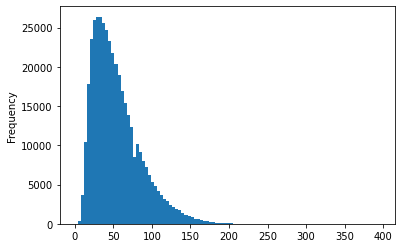

In [96]:
data['len'] = data['text'].apply(lambda s : len(s))
data['len'].plot.hist(bins=100)

In [98]:
data.len.quantile(0.75) # 130 will be the max_length of sequence

71.0

In [9]:
maxlen = 75 # max number of words in a review to use


In [10]:
X = data['text']
X = list(X)
y = data['emotions'].values

### Label Binarize

In [11]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y)
y_labels = lb.transform(y)

In [127]:
lb.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], dtype='<U8')

In [143]:
np.unique(lb.inverse_transform(y_labels))

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], dtype='<U8')

In [133]:

len(X)

416809

### Text Feature Generation

In [12]:
# Tokenize text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
train_X = tokenizer.texts_to_sequences(X)

# vocabulary
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)


Vocabulary size: 67516


In [135]:
with open('word_index.json', 'w') as f:
    json.dump(word_index, f)
with open('index_word.json', 'w') as f2:
    json.dump(tokenizer.index_word, f2)

In [137]:
print('Shape of data tensor:', train_X.shape)
print('Shape of label tensor:', y_labels.shape)

Shape of data tensor: (416809, 75)
Shape of label tensor: (416809, 6)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_X, y_labels,
                                                    stratify=y_labels, 
                                                    test_size=0.25)

In [146]:
print('Number of entries in each emotion class:')
print('training: ', y_train.sum(axis=0))
print('test: ', y_test.sum(axis=0))

Number of entries in each emotion class:
training:  [ 42988  35784 105800  25915  90890  11229]
test:  [14329 11928 35267  8639 30297  3743]


### Load Pre-trained Glove Vectors

In [14]:
glove_vectors = dict()
# Creating Dictionary of Word and corresponding Vectors
file = open('/content/drive/My Drive/glove.6B.200d.txt',encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0] # each word 
    vectors = np.asarray(values[1:],dtype='float32')
    glove_vectors[word] = vectors
file.close()

In [15]:
embedding_matrix = np.random.random((len(word_index) + 1, embed_size))


In [17]:
for word,index in word_index.items():
    if index >= max_features:
        continue
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        embedding_vector = glove_vectors.get(word.capitalize())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print('Completed creating embedding matrix')

Completed creating embedding matrix


In [18]:
print("Shape of embedding matrix is {}".format(np.shape(embedding_matrix)))

Shape of embedding matrix is (67517, 200)


### LSTM MODEL

In [162]:
model = Sequential()
model.add(Embedding(len(word_index)+1,embed_size,weights=[embedding_matrix], input_length=maxlen,trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, recurrent_dropout=0.2,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))



In [163]:
model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

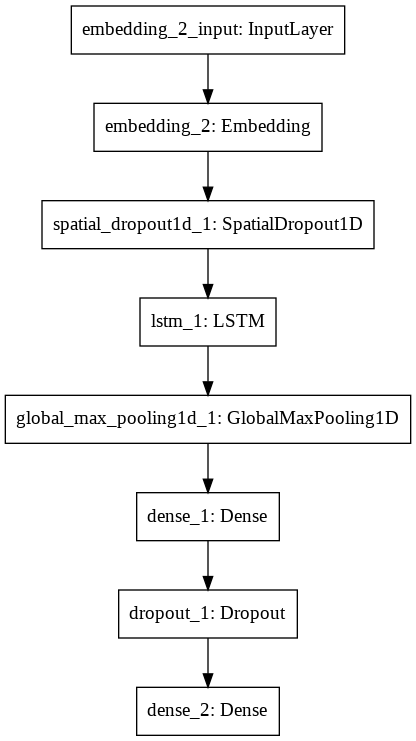

In [164]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

In [166]:
history = model.fit(X_train, y_train, epochs = 5, batch_size=128, validation_data=(X_test, y_test))

Train on 312606 samples, validate on 104203 samples
Epoch 1/5
312606/312606 [==============================] - 323s 1ms/step - loss: 0.3879 - accuracy: 0.8519 - val_loss: 0.1283 - val_accuracy: 0.9308
Epoch 2/5
312606/312606 [==============================] - 327s 1ms/step - loss: 0.1545 - accuracy: 0.9256 - val_loss: 0.1092 - val_accuracy: 0.9340
Epoch 3/5
312606/312606 [==============================] - 325s 1ms/step - loss: 0.1294 - accuracy: 0.9304 - val_loss: 0.1050 - val_accuracy: 0.9356
Epoch 4/5
312606/312606 [==============================] - 327s 1ms/step - loss: 0.1193 - accuracy: 0.9329 - val_loss: 0.1029 - val_accuracy: 0.9352
Epoch 5/5
312606/312606 [==============================] - 331s 1ms/step - loss: 0.1146 - accuracy: 0.9343 - val_loss: 0.1016 - val_accuracy: 0.9352


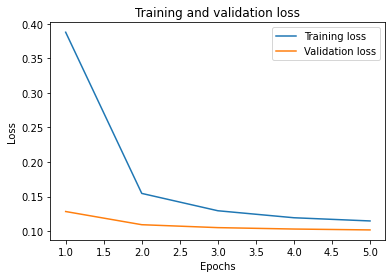

In [167]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

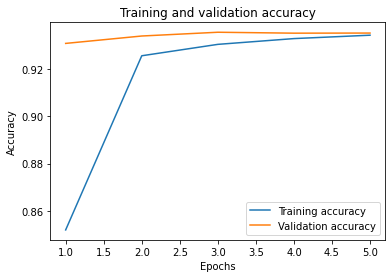

In [168]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [171]:
print("Accuracy in the test set:")
model.evaluate(X_test, y_test)[1]

Accuracy in the test set:
104203/104203 [==============================] - 38s 367us/step


0.9352225661277771

In [173]:
model.save('emotion_lstm_model.h5')

In [177]:
predictions = model.predict_classes(X_test)

### Predict on New Text

In [186]:
def predict_emotion(text):
    sequences = tokenizer.texts_to_sequences([text])
    pad_seq = pad_sequences(sequences, maxlen=maxlen)
    pred = model.predict_classes(pad_seq)
    return pred

int2label = {
    0: 'anger',
    1: 'fear',
    2: 'joy',
    3: 'love',
    4: 'sadness',
    5: 'surprise'
}
import random
sample_text = "I am so sad today that I have not ate properly"
prediction = predict_emotion(sample_text)
prediction = int2label[int(prediction)]
print('The predicted label of the text is {}: '.format(prediction))



The predicted label of the text is sadness: 


### CNN MODEL

In [187]:
model = Sequential()
model.add(Embedding(len(word_index)+1,embed_size,weights=[embedding_matrix], input_length=maxlen,trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(50,
                 3,padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())
# We add a vanilla hidden layer:
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a 6 unit output layer,:
model.add(Dense(6))
model.add(Activation('softmax'))
    # compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
print(model.summary())
history=model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=128)    




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 75, 200)           13503400  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 75, 200)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 73, 50)            30050     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 100)              

In [190]:
print("Accuracy in the test set:")
model.evaluate(X_test, y_test)[1]

Accuracy in the test set:
104203/104203 [==============================] - 6s 54us/step


0.9155590534210205

In [191]:
model.save('emotion_cnn_model.h5')

### Predict on New Text

In [192]:
def predict_emotion(text):
    sequences = tokenizer.texts_to_sequences([text])
    pad_seq = pad_sequences(sequences, maxlen=maxlen)
    pred = model.predict_classes(pad_seq)
    return pred

int2label = {
    0: 'anger',
    1: 'fear',
    2: 'joy',
    3: 'love',
    4: 'sadness',
    5: 'surprise'
}
import random
sample_text = "I am so sad today that I have not ate properly"
prediction = predict_emotion(sample_text)
prediction = int2label[int(prediction)]
print('The predicted label of the text is {}: '.format(prediction))



The predicted label of the text is sadness: 


In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

y_pred = model.predict_classes(X_test)

### Plot Graphs

In [208]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap="YlGnBu"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def full_multiclass_report(model,
                           x,
                           y_true,y_pred,classes,binary = False):


    
    y_true = np.argmax(y_true,axis=1)
   
    #  Print accuracy score
    print("Accuracy : "+ str(metrics.accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    #  Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    TP = np.diag(cnf_matrix)
    FP = np.sum(cnf_matrix, axis=0) - TP
    FN = np.sum(cnf_matrix, axis=1) - TP
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    print("Precision : ", precision)
    print("Recall : ", recall)
    plot_confusion_matrix(cnf_matrix,classes)


Accuracy : 0.9155590530023128

Classification Report
              precision    recall  f1-score   support

           0    0.87419   0.97229   0.92064     14329
           1    0.94699   0.80869   0.87239     11928
           2    0.97045   0.89387   0.93058     35267
           3    0.75626   0.95752   0.84507      8639
           4    0.96092   0.93824   0.94945     30297
           5    0.71001   0.96286   0.81733      3743

    accuracy                        0.91556    104203
   macro avg    0.86980   0.92225   0.88924    104203
weighted avg    0.92464   0.91556   0.91688    104203

Precision :  [0.87419213 0.94698606 0.97044699 0.75626257 0.96092218 0.71000788]
Recall :  [0.97229395 0.80868545 0.89386679 0.95751823 0.93824471 0.96286401]


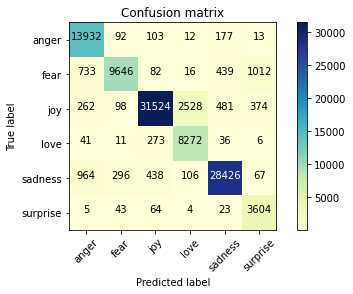

In [209]:

full_multiclass_report(model,
                       X_test,
                       y_test,y_pred,class_names)

In [210]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

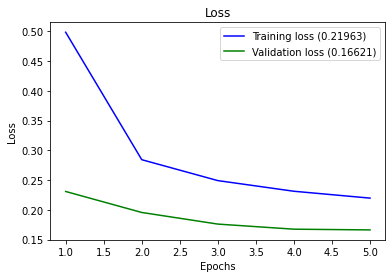

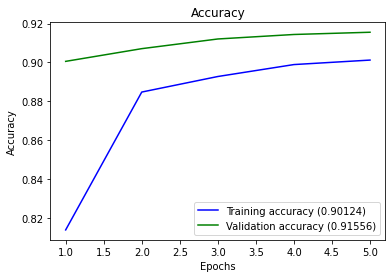

In [211]:
plot_history(history)

In [38]:
model = Sequential()
model.add(Embedding(len(word_index)+1,embed_size,weights=[embedding_matrix], input_length=maxlen,trainable=False))
model.add(Conv1D(128,kernel_size=5,padding='valid',activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.3))
model.add(Conv1D(64,kernel_size=5,padding='valid',activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(100,kernel_initializer='glorot_normal',activation='relu'))
model.add(Dense(64,kernel_initializer='glorot_normal',activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])


In [39]:
history=model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=128)    


Train on 312606 samples, validate on 104203 samples
Epoch 1/5
312606/312606 [==============================] - 31s 100us/step - loss: 0.9025 - accuracy: 0.6596 - val_loss: 0.5624 - val_accuracy: 0.7756
Epoch 2/5
312606/312606 [==============================] - 30s 97us/step - loss: 0.6359 - accuracy: 0.7566 - val_loss: 0.5238 - val_accuracy: 0.7854
Epoch 3/5
312606/312606 [==============================] - 31s 100us/step - loss: 0.5901 - accuracy: 0.7675 - val_loss: 0.5130 - val_accuracy: 0.7866
Epoch 4/5
312606/312606 [==============================] - 30s 97us/step - loss: 0.5669 - accuracy: 0.7735 - val_loss: 0.4909 - val_accuracy: 0.7878
Epoch 5/5
312606/312606 [==============================] - 30s 97us/step - loss: 0.5517 - accuracy: 0.7773 - val_loss: 0.4848 - val_accuracy: 0.7927


In [40]:
model.save('CNN2layer_model.h5')

In [43]:
from keras.models import load_model
model = load_model('CNN2layer_model.h5')